# <center>Finding the Best Area to Live for Birdwatchers in SIngapore</center>
## <center>IBM Data Science Professional Certificate Capstone Project</center>



## Table of Contents
- [Introduction](#introduction)
- [Data](#)
- [Methodology](#methodology)
- [Results](#results)
- [Discussion](#discussion)
- [Conclusion](#conclusion)
- [References](#references)


## Introduction <a name='introduction'></a>

Humans have a innate instinct to connect with nature and other living beings ([1](#r1)). One such connection is through watching birds in their habitat. Indeed, birdwatching is a popular hobby around the world ([2](#r2)). Some people, including the author, can have stronger need to connect with nature more than others. This need can influence their buying decisions, such as choosing a place of residence. In connection with the birdwatching activity, factors that maximize the birdwatching experience in an area, such as bird abundance and diversity, can affect whether a birdwatching enthusiast would decide to live in that area or not.

Singapore is a country in South East Asia. The country is a well developed island city state with numerous venues or facilities such as restaurants, medical centers, malls,  schools, parks, and transit systems all over the country built by/for the people. It was chosen as the subject area of this study because the bird observation data from there is extensive, the area is not too large but also not too small, it is a city that the author has visited several times, and the Foursquare API data from the area (that this study used) seemed updated enough.

The goal of this study is to help birdwatching enthusiasts choose an area to live in Singapore with maximum birdwatching experience while also considering availability of important venues using machine learning.

## Data <a name='data'></a>

There are two datasets that were used in this study. The first is Singapore bird observation data obtained from The Global Biodiversity Information Facility (GBIF) ([3](#r3)). This dataset contains 423211 rows of Singapore bird observations from year 1800 to 2020. The second dataset is the venues data from the Foursquare API.

## Methodology <a name='methodology'></a>

**Data acquisition**

A query in GBIF was made for all available records data for birds of Singapore. The resulting dataset consists of 423211 rows and 249 columns.
Data preprocessing
The acquired dataset was then cleaned from unused columns and missing data. The process was conducted with Microsoft Excel.  The resulting dataset contained 401607 rows and 4 columns. The 4 columns were: latitude, longitude, species name, species id.

**Sectors determination**

To convert the data points into a more manageable form, a clustering was performed using latitude and longitude features of the data. The result was 40 clusters of data, which we called sectors, from sector 0 to sector 39. The quantity of 40 was chosen because the resulting clusters seemed to have the right sizes, specifically for exploration through walking or taking a short trip on bus. For each sectors, a center was determined.

**Venues exploration**

For each of the 40 sector centers, 3 API calls were made to the Foursquare API. Each API calls requested venues of certain categories within 1 km radius of the centers. The first API call requested venues data of the category ‘Food’ that contained restaurants, cafes, bars, etc. This first API call requested 10 results. The second and third API requested venue data of categories that were considered important and desirable features for a person to choose to live in the area. Such categories were: residence area, transit system, medical center, convenience store, mall, park, school, university, nature reserve. The second API call requested 50 results, while the third call requested 40. So for each of the 40 sector centers, the maximum API call result was 100 venues within 1 km of the centers.

**More processing**

The top 10 most popular venue types were calculated for each sectors. The species data were aggregated to obtain the number of uniques species for each sectors. To prepare for cluster analysis, the venue types data were transformed into integer data with one-hot encoding using the mean.

**Clustering**

Clustering analysis were implemented on the prepared data using k-means clustering algorithm. To determine the optimum number of k, Yellowbrick library were used. The elbow method visualization were produced quickly with Yellowbrick. The resulting cluster data with the optimum k were then merged with the species numbers data for each sectors and the sectors data that contain the top 5 most popular venue types for each sectors.

**Mapping**

The final clustering result were then mapped using Folium library.

### Imports libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.preprocessing import StandardScaler
import time
import json
import requests
from pandas.io.json import json_normalize
from geopy.geocoders import Nominatim
import matplotlib.cm as cm
import matplotlib.colors as colors
import folium

%matplotlib inline

### Read Singapore bird observation data from GBIF

In [2]:
df_bird = pd.read_csv('singapore_bird_data_gbif_2021_01_13d.csv')
df_bird.head()

,decimalLatitude,decimalLongitude,acceptedNameUsageID,species
0,1.37076,103.826,6101205,Chrysophlegma miniaceum
1,1.41827,103.729,2489036,Aplonis panayensis
2,1.41827,103.729,2480849,Ixobrychus cinnamomeus
3,1.41955,103.729,5228803,Dinopium javanense
4,1.33690,103.966,5229045,Psittacula alexandri


In [3]:
df_bird.shape

(401067, 4)

### Create simple plot of all bird observation data points

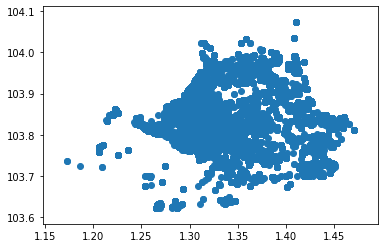

In [4]:
X = df_bird[['decimalLatitude', 'decimalLongitude']]
plt.scatter(X['decimalLatitude'], X['decimalLongitude'])

### Create clusters from the observation data points using k-means clustering

In [5]:
k_means = KMeans(init='k-means++', n_clusters = 40, random_state = 0)
k_means.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=40, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=0, tol=0.0001, verbose=0)

In [6]:
sector = k_means.labels_
center = k_means.cluster_centers_

### Plot the sectors created from the clustering of bird observation data

<function matplotlib.pyplot.show(*args, **kw)>

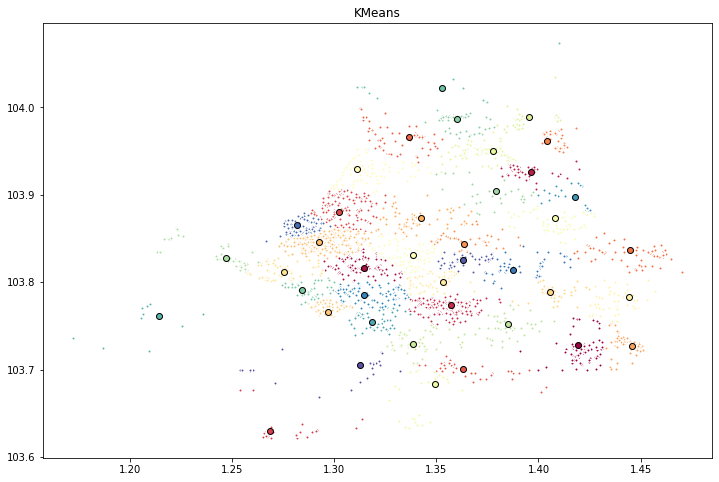

In [7]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(1,1,1)
colors = plt.cm.Spectral(np.linspace(0,1,len(set(sector))))

for k, col in zip(range(40), colors):
    members = np.where(sector==k)
    sector_center = center[k]
    for i in members:
        px = X.iloc[i, 0]
        py = X.iloc[i, 1]
        ax.plot(px, py, 'w', markerfacecolor=col, marker='.')
        ax.plot(sector_center[0], sector_center[1], 'o', markerfacecolor=col, markeredgecolor='k', markersize=6)

ax.set_title('KMeans')
plt.show

In [8]:
df_bird['sector'] = sector
df_bird.head()

,decimalLatitude,decimalLongitude,acceptedNameUsageID,species,sector
0,1.37076,103.826,6101205,Chrysophlegma miniaceum,38
1,1.41827,103.729,2489036,Aplonis panayensis,0
2,1.41827,103.729,2480849,Ixobrychus cinnamomeus,0
3,1.41955,103.729,5228803,Dinopium javanense,0
4,1.33690,103.966,5229045,Psittacula alexandri,7


### Assign sector numbers to each cluster centers

In [9]:
closest, _ = pairwise_distances_argmin_min(center, X)
closest = closest.tolist()
centers = center.tolist()
df_center = pd.DataFrame(centers, columns=['center_lat', 'center_lon'])
df_center['closest'] = closest

center_sectors = []

for i in df_center['closest']:
    sector = df_bird.iloc[i, 4]
    center_sectors.append(sector)
    
df_center['sector'] = center_sectors
df_center = df_center.drop(['closest'], axis=1)

df_center.head()

,center_lat,center_lon,sector
0,1.419471,103.727489,0
1,1.314832,103.816201,1
2,1.396323,103.926179,2
3,1.357278,103.773335,3
4,1.268861,103.629649,4


### Map the sectors using Folium

In [10]:
address = 'Singapore'
geolocator = Nominatim(user_agent='sg_explorer')
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('Geographical coordinates of Singapore are {}, {}'.format(latitude, longitude))

Geographical coordinates of Singapore are 1.357107, 103.8194992


In [11]:
map_sg = folium.Map(location=[latitude, longitude], zoom_start=11)

for lat, lng, label in zip(df_center['center_lat'], df_center['center_lon'], df_center['sector']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat,lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_sg)

map_sg

### Define credentials for Foursquare API

In [12]:
# The code was removed by Watson Studio for sharing.

### Define function to call Foursquare API for venues in the redius of 1000 m around a sector center in the 'Food' category and then run the function

In [13]:
def getNearbyFood(sector, latitudes, longitudes, radius=1000):
    venues_list=[]
    for sector, lat, lng in zip(sector, latitudes, longitudes):
        url = 'https://api.foursquare.com/v2/venues/explore?\
                &client_id={}\
                &client_secret={}\
                &v={}\
                &ll={},{}\
                &radius={}\
                &categoryId=4d4b7105d754a06374d81259\
                &limit={}'\
                .format(\
                CLIENT_ID,\
                CLIENT_SECRET,\
                VERSION,\
                lat,\
                lng,\
                radius,\
                10)
            
        results = requests.get(url).json()["response"]['groups'][0]['items']
        time.sleep(2)
        venues_list.append([(sector, lat, lng, v['venue']['name'], v['venue']['id'], v['venue']['categories'][0]['name']) for v in results])

    nearby_food = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_food.columns = ['sector', 'sector_lat', 'sector_lon', 'venue_name', 'venue_id', 'venue_category']
    
    return(nearby_food)

In [14]:
df_explore_cent = getNearbyFood(sector=df_center['sector'],
                             latitudes=df_center['center_lat'],
                             longitudes=df_center['center_lon'])

In [15]:
df_explore_cent['venue_type'] = 'Food'
df_explore_cent.head()

,sector,sector_lat,sector_lon,venue_name,venue_id,venue_category,venue_type
0,0,1.419471,103.727489,The Golfers' Terrace,4d54fc4ca05c370403f9b287,Snack Place,Food
1,0,1.419471,103.727489,The Terrace Cafe,533b8d7e498ec4e05921f2b4,Café,Food
2,0,1.419471,103.727489,My Cafe,567f4481498ec26fa4ad8414,Café,Food
3,0,1.419471,103.727489,D'Natel @ D'Kranji Farm Resort,4d6748cc9792b1f7dbf93b1f,Asian Restaurant,Food
4,1,1.314832,103.816201,Corner House,53b67ff6498ed182152a0e25,French Restaurant,Food


### Define function to call Foursquare API for venues in the redius of 1000 m around a sector center in the 'Residence', 'Medical Center', 'Transit System', 'Nature Reserve', 'Park' category and then run the function

In [16]:
def getNearbyVitals1(sector, latitudes, longitudes, radius=1000):
    venues_list=[]
    for sector, lat, lng in zip(sector, latitudes, longitudes):
        url = 'https://api.foursquare.com/v2/venues/explore?\
                &client_id={}\
                &client_secret={}\
                &v={}\
                &ll={},{}\
                &radius={}\
                &categoryId=4bf58dd8d48988d103941735,4f2a210c4b9023bd5841ed28,4d954b06a243a5684965b473,4bf58dd8d48988d194941735,4bf58dd8d48988d177941735,4bf58dd8d48988d196941735,4bf58dd8d48988d1fe931735,4bf58dd8d48988d12b951735,52f2ab2ebcbc57f1066b8b4f,4bf58dd8d48988d129951735,4f4531504b9074f6e4fb0102,4bf58dd8d48988d12a951735,4bf58dd8d48988d1fc931735,4bf58dd8d48988d1fd931735,56aa371be4b08b9a8d573544,4bf58dd8d48988d1e2941735,52e81612bcbc57f1066b7a22,52e81612bcbc57f1066b7a21,52e81612bcbc57f1066b7a13,4bf58dd8d48988d163941735,4bf58dd8d48988d15a941735,4bf58dd8d48988d17b941735,58daa1558bbb0b01f18ec1fd,4bf58dd8d48988d182941735,5109983191d435c0d71c2bb1,4bf58dd8d48988d1e0941735,52e81612bcbc57f1066b7a23,4bf58dd8d48988d159941735\
                &limit={}'\
                .format(\
                CLIENT_ID,\
                CLIENT_SECRET,\
                VERSION,\
                lat,\
                lng,\
                radius,\
                50)
            
        results = requests.get(url).json()["response"]['groups'][0]['items']
        time.sleep(2)
        venues_list.append([(sector, lat, lng, v['venue']['name'], v['venue']['id'], v['venue']['categories'][0]['name']) for v in results])

    nearby_vitals1 = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_vitals1.columns = ['sector', 'sector_lat', 'sector_lon', 'venue_name', 'venue_id', 'venue_category']
    
    return(nearby_vitals1)

In [17]:
df_explore_cent2 = getNearbyVitals1(sector=df_center['sector'],
                             latitudes=df_center['center_lat'],
                             longitudes=df_center['center_lon'])
df_explore_cent2['venue_type'] = ''
df_explore_cent2.head()

,sector,sector_lat,sector_lon,venue_name,venue_id,venue_category,venue_type
0,0,1.419471,103.727489,Kranji Marshes,4f58a2e2e4b0937647b8b396,Nature Preserve,
1,1,1.314832,103.816201,Singapore Botanic Gardens,4b3b3bd0f964a520ac7125e3,Botanical Garden,
2,1,1.314832,103.816201,The Rain Forest,4cb028b6cbab236a33279e73,Park,
3,1,1.314832,103.816201,Evolution Garden,4da8e987fa8cc764970c51ca,Garden,
4,1,1.314832,103.816201,National Orchid Garden,4bd17ec777b29c74eaa48c82,Garden,


### Define function to call Foursquare API for venues in the redius of 1000 m around a sector center in the 'School', 'Mall', 'College' category and then run the function

In [18]:
def getNearbyVitals2(sector, latitudes, longitudes, radius=1000):
    venues_list=[]
    for sector, lat, lng in zip(sector, latitudes, longitudes):
        url = 'https://api.foursquare.com/v2/venues/explore?\
                &client_id={}\
                &client_secret={}\
                &v={}\
                &ll={},{}\
                &radius={}\
                &categoryId=4bf58dd8d48988d1fd941735,5744ccdfe4b0c0459246b4dc,4bf58dd8d48988d17f941735,4d954b0ea243a5684a65b473,4bf58dd8d48988d1f6941735,4bf58dd8d48988d118951735,52f2ab2ebcbc57f1066b8b46,50be8ee891d4fa8dcc7199a7,4f4533804b9074f6e4fb0105,4bf58dd8d48988d13d941735,4f4533814b9074f6e4fb0106,52e81612bcbc57f1066b7a45,4f4533814b9074f6e4fb0107,4d4b7105d754a06372d81259\
                &limit={}'\
                .format(\
                CLIENT_ID,\
                CLIENT_SECRET,\
                VERSION,\
                lat,\
                lng,\
                radius,\
                40)
            
        results = requests.get(url).json()["response"]['groups'][0]['items']
        time.sleep(2)
        venues_list.append([(sector, lat, lng, v['venue']['name'], v['venue']['id'], v['venue']['categories'][0]['name']) for v in results])

    nearby_vitals2 = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_vitals2.columns = ['sector', 'sector_lat', 'sector_lon', 'venue_name', 'venue_id', 'venue_category']
    
    return(nearby_vitals2)

In [19]:
df_explore_cent3 = getNearbyVitals2(sector=df_center['sector'],
                             latitudes=df_center['center_lat'],
                             longitudes=df_center['center_lon'])

df_explore_cent3.head()

,sector,sector_lat,sector_lon,venue_name,venue_id,venue_category
0,1,1.314832,103.816201,Cluny Court,4b334576f964a520631825e3,Shopping Mall
1,1,1.314832,103.816201,Cold Storage,4b88b35ef964a5208e0932e3,Supermarket
2,1,1.314832,103.816201,Shell Dunearn University,4bb89a6acf2fc9b626a69f02,Gas Station
3,1,1.314832,103.816201,Kids Empire,5057f55fe4b0e276715739b7,Nursery School
4,1,1.314832,103.816201,Cheers,4eb78e176c2590eb88f1d87e,Convenience Store


In [20]:
df_explore_cent3['venue_type'] = ''
df_explore_cent3.head()

,sector,sector_lat,sector_lon,venue_name,venue_id,venue_category,venue_type
0,1,1.314832,103.816201,Cluny Court,4b334576f964a520631825e3,Shopping Mall,
1,1,1.314832,103.816201,Cold Storage,4b88b35ef964a5208e0932e3,Supermarket,
2,1,1.314832,103.816201,Shell Dunearn University,4bb89a6acf2fc9b626a69f02,Gas Station,
3,1,1.314832,103.816201,Kids Empire,5057f55fe4b0e276715739b7,Nursery School,
4,1,1.314832,103.816201,Cheers,4eb78e176c2590eb88f1d87e,Convenience Store,


In [21]:
df_explore_cent.to_csv('explore_cent.csv', index=False)
df_explore_cent2.to_csv('explore_cent2.csv', index=False)
df_explore_cent3.to_csv('explore_cent3.csv', index=False)

### Combine all the data from Foursquare API calls except from the 'Food' category into one dataframe

In [22]:
df_explore1 = pd.concat([df_explore_cent2, df_explore_cent3])
df_explore1.head()

,sector,sector_lat,sector_lon,venue_name,venue_id,venue_category,venue_type
0,0,1.419471,103.727489,Kranji Marshes,4f58a2e2e4b0937647b8b396,Nature Preserve,
1,1,1.314832,103.816201,Singapore Botanic Gardens,4b3b3bd0f964a520ac7125e3,Botanical Garden,
2,1,1.314832,103.816201,The Rain Forest,4cb028b6cbab236a33279e73,Park,
3,1,1.314832,103.816201,Evolution Garden,4da8e987fa8cc764970c51ca,Garden,
4,1,1.314832,103.816201,National Orchid Garden,4bd17ec777b29c74eaa48c82,Garden,


### Map the default venue category names into predefined venue type name to make them more uniform

In [23]:
map = {'CafÃ©': 'Food', 'Coffee Shop': 'Food',
        'Snack Place': 'Food',
        'Student Center': 'College',
        'School': 'School',
        'Scenic Lookout': 'Park',
        'Hot Dog Joint': 'Food',
        'General College & University': 'College',
        'Medical Center': 'Clinic',
        'Pier': 'Coast',
        'College Residence Hall': 'College',
        'College Classroom': 'College',
        'University': 'College',
        'College Academic Building': 'College',
        'Law School': 'College',
        'College Stadium': 'College',
        'College Engineering Building': 'College',
        'Community College': 'College',
        'Eastern European Restaurant': 'Food',
        'Restaurant': 'Food',
        'Tea Room': 'Food',
        'CafÃ©': 'Food',
        'Food Court': 'Food',
        'Food & Drink Shop': 'Food',
        'Gastropub': 'Food',
        'Health Food Store': 'Food',
        'Hospital Ward': 'Hospital',
        'Theater': 'Movie Theater',
        'Mountain': 'Nature Reserve',
        'Sculpture Garden': 'Park',
        'Bike Trail': 'Trail',
        'Playground': 'Park',
        'Water Park': 'Park',
        'Island': 'Coast',
        'Home (private)': 'Residence',
        'Housing Development': 'Residence',
        'Residential Building (Apartment / Condo)': 'Residence',
        'Emergency Room': 'Hospital',
        "Doctor's Office": 'Clinic',
        'Hospital': 'Hospital',
        'Bus Station': 'Bus Transit',
        'Bus Line': 'Bus Transit',
        'Bus Stop': 'Bus Transit',
        'Train Station': 'Rail Transit',
        'Platform': 'Rail Transit',
        'Train': 'Rail Transit',
        'Light Rail Station': 'Rail Transit',
        'Metro Station': 'Rail Transit',
        'Bay': 'Coast',
        'Beach': 'Coast',
        'Botanical Garden': 'Park',
        'National Park': 'Nature Reserve',
        'Nature Preserve': 'Nature Reserve',
        'Park': 'Park',
        'Garden': 'Park',
        'Zoo': 'Zoo',
        'Zoo Exhibit': 'Zoo',
        'Theme Park': 'Theme Park',
        'Theme Park Ride / Attraction': 'Theme Park',
        'Harbor / Marina': 'Coast',
        'Forest': 'Nature Reserve',
        'Trail': 'Trail',
        'Shopping Mall': 'Mall',
        'Shopping Plaza': 'Mall',
        'Movie Theater': 'Movie Theater',
        'Convenience Store': 'Convenience Store',
        'Department Store': 'Convenience Store',
        'Grocery Store': 'Convenience Store',
        'Supermarket': 'Convenience Store',
        'Market': 'Market',
        'Elementary School': 'Elementary School',
        'High School': 'High School',
        'Middle School': 'Middle School',
        'Preschool': 'Preschool',
        'Nursery School': 'Preschool',
        'College & University': 'College'}

In [27]:
df_explore1['venue_type'] = df_explore1['venue_category'].map(map)
df_explore1.to_csv('explore1.csv', index=False)
df_explore1['venue_category'].unique()

array(['Nature Preserve', 'Botanical Garden', 'Park', 'Garden', 'Trail',
       'Metro Station', 'Office', 'Monument / Landmark',
       'Eastern European Restaurant', 'Medical Center',
       'Research Station', 'Bus Stop', 'Bus Line', 'Bus Station',
       'Residential Building (Apartment / Condo)', 'Hospital',
       "Doctor's Office", 'Playground', 'Bridge', 'Harbor / Marina',
       'Waterfront', 'Lake', 'Scenic Lookout', 'Bike Trail', 'Pool',
       'Housing Development', 'Gym Pool', 'Building', 'Road',
       'Convention Center', 'Train Station', 'Beach', 'Zoo Exhibit',
       'Nightclub', 'Theme Park Ride / Attraction',
       'General Entertainment', 'Shopping Mall', 'Shopping Plaza', 'Pier',
       'General Travel', 'Zoo', 'Outdoor Event Space', 'Exhibit',
       'Performing Arts Venue', 'Light Rail Station', 'Theater',
       'Mountain', 'Forest', 'Tea Room', 'Gas Station', 'Hotel',
       'Veterinarian', 'Flower Shop', 'Bay', 'Emergency Room',
       'Hospital Ward', 'Café'

In [28]:
df_explore1['venue_type'].unique()

array(['Nature Reserve', 'Park', 'Trail', 'Rail Transit', nan, 'Food',
       'Clinic', 'Bus Transit', 'Residence', 'Hospital', 'Coast', 'Zoo',
       'Theme Park', 'Mall', 'Movie Theater', 'College',
       'Convenience Store', 'Preschool', 'High School', 'School',
       'Elementary School', 'Middle School', 'Market'], dtype=object)

In [29]:
df_explore1 = df_explore1.dropna()

### Combine all the data from Foursquare API calls into one dataframe and drop rows with null values

In [30]:
df_explore = pd.concat([df_explore_cent, df_explore1])
df_explore = df_explore.dropna()

In [31]:
df_explore.to_csv('explore.csv')

### Aggregate the number of unique bird species found on each sectors

In [103]:
df_bird = df_bird.sort_values(by=['sector', 'species'])
df_bird_count = df_bird.drop_duplicates(subset=['sector', 'species'])

df_bird_count = df_bird_count.groupby('sector')['species'].nunique()

df_bird_count = df_bird_count.reset_index()

df_bird_count = df_bird_count.rename(columns={'species': 'species_number'})

df_bird_count.to_csv('sp_unique_sector.csv', index=False)
df_bird_count.head()

,sector,species_number
0,0,239
1,1,208
2,2,230
3,3,239
4,4,206


### Create one-hot encoding for venue types data that is collected from Foursquare API

In [104]:
df_onehot = df_explore.drop(['sector_lat', 'sector_lon', 'venue_name', 'venue_id', 'venue_category'], axis=1)

df_onehot.shape

(2095, 2)

In [105]:
df_onehot = pd.get_dummies(df_onehot['venue_type'])

### Reassigned the sector column that was omitted on the one-hot encoding process

In [106]:
df_onehot['sector'] = df_explore['sector']
columns = [df_onehot.columns[-1]] + list(df_onehot.columns[:-1])
df_onehot = df_onehot[columns]
df_onehot.head()

,sector,Bus Transit,Clinic,Coast,College,Convenience Store,Elementary School,Food,High School,Hospital,...,Movie Theater,Nature Reserve,Park,Preschool,Rail Transit,Residence,School,Theme Park,Trail,Zoo
0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


### Create aggregate of venue types number per sector

In [107]:
df_onehot_sum = df_onehot.groupby('sector').sum()
df_onehot_sum.to_csv('sector_venue_types_sum.csv')
df_onehot_sum.head()

,Bus Transit,Clinic,Coast,College,Convenience Store,Elementary School,Food,High School,Hospital,Mall,...,Movie Theater,Nature Reserve,Park,Preschool,Rail Transit,Residence,School,Theme Park,Trail,Zoo
sector,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,4,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,6,4,0,11,4,0,11,1,9,2,...,0,0,22,1,1,1,1,0,3,0
2,0,0,2,0,1,1,6,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,15,1,0,2,3,0,11,0,0,1,...,1,1,2,1,2,10,1,0,15,0
4,0,0,0,0,0,0,3,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Create aggregate of venue types number per sector

In [108]:
df_onehot_mean = df_onehot.groupby('sector').mean()
df_onehot_mean.to_csv('sector_venue_types_mean.csv')
df_onehot_mean.head()

,Bus Transit,Clinic,Coast,College,Convenience Store,Elementary School,Food,High School,Hospital,Mall,...,Movie Theater,Nature Reserve,Park,Preschool,Rail Transit,Residence,School,Theme Park,Trail,Zoo
sector,,,,,,,,,,,,,,,,,,,,,
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.800000,0.000000,0.000000,0.000000,...,0.000000,0.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0
1,0.077922,0.051948,0.000000,0.142857,0.051948,0.000000,0.142857,0.012987,0.116883,0.025974,...,0.000000,0.000000,0.285714,0.012987,0.012987,0.012987,0.012987,0.0,0.038961,0.0
2,0.000000,0.000000,0.181818,0.000000,0.090909,0.090909,0.545455,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.090909,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0
3,0.227273,0.015152,0.000000,0.030303,0.045455,0.000000,0.166667,0.000000,0.000000,0.015152,...,0.015152,0.015152,0.030303,0.015152,0.030303,0.151515,0.015152,0.0,0.227273,0.0
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0


### Merge venue types data and the species number per sector as features for cluster analysis

In [109]:
df_features = pd.merge(df_bird_count, df_onehot_mean, on='sector')
df_features.to_csv('features.csv', index=False)
df_features.head()

,sector,species_number,Bus Transit,Clinic,Coast,College,Convenience Store,Elementary School,Food,High School,...,Movie Theater,Nature Reserve,Park,Preschool,Rail Transit,Residence,School,Theme Park,Trail,Zoo
0,0,239,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.800000,0.000000,...,0.000000,0.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0
1,1,208,0.077922,0.051948,0.000000,0.142857,0.051948,0.000000,0.142857,0.012987,...,0.000000,0.000000,0.285714,0.012987,0.012987,0.012987,0.012987,0.0,0.038961,0.0
2,2,230,0.000000,0.000000,0.181818,0.000000,0.090909,0.090909,0.545455,0.000000,...,0.000000,0.000000,0.090909,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0
3,3,239,0.227273,0.015152,0.000000,0.030303,0.045455,0.000000,0.166667,0.000000,...,0.015152,0.015152,0.030303,0.015152,0.030303,0.151515,0.015152,0.0,0.227273,0.0
4,4,206,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0


### Calculate most common venue types for each sectors

In [110]:
def most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    return row_categories_sorted.index.values[0:num_top_venues]

In [111]:
num_top_venues = 10
indicators = ['st', 'nd', 'rd']
columns = ['sector']
df_onehot_mean = df_onehot_mean.reset_index()

for i in np.arange(num_top_venues):
    try:
        columns.append('{}{}_most_common_venue'.format(i+1, indicators[i]))
    except:
        columns.append('{}th_most_common_venue'.format(i+1))
sector_venues_sorted = pd.DataFrame(columns=columns)
sector_venues_sorted['sector'] = df_onehot_mean['sector']

for i in np.arange(df_onehot_mean.shape[0]):
    sector_venues_sorted.iloc[i, 1:] = most_common_venues(df_onehot_mean.iloc[i, :], num_top_venues)
    
sector_venues_sorted

,sector,1st_most_common_venue,2nd_most_common_venue,3rd_most_common_venue,4th_most_common_venue,5th_most_common_venue,6th_most_common_venue,7th_most_common_venue,8th_most_common_venue,9th_most_common_venue,10th_most_common_venue
0,0,Food,Nature Reserve,Zoo,Mall,Clinic,Coast,College,Convenience Store,Elementary School,High School
1,1,Park,College,Food,Hospital,Bus Transit,Clinic,Convenience Store,Trail,Mall,School
2,2,Food,Coast,Convenience Store,Elementary School,Park,Zoo,Mall,Clinic,College,High School
3,3,Bus Transit,Trail,Food,Residence,Convenience Store,Rail Transit,Park,College,Clinic,School
4,4,Food,Zoo,Trail,Clinic,Coast,College,Convenience Store,Elementary School,High School,Hospital
5,5,Bus Transit,Residence,Food,Convenience Store,College,Clinic,Preschool,Mall,High School,Rail Transit
6,6,Food,Bus Transit,Park,Mall,Clinic,Coast,College,Convenience Store,Elementary School,High School
7,7,Bus Transit,Food,Convenience Store,Park,College,Residence,Clinic,Rail Transit,Mall,Preschool
8,8,Residence,Bus Transit,Food,Convenience Store,Park,Mall,Market,Trail,Rail Transit,Elementary School
9,9,Food,Convenience Store,Trail,Coast,Zoo,Clinic,College,Elementary School,High School,Hospital


### Prepare and normalize features for cluster analysis with k-means clustering algorithm

In [112]:
df_X = df_features.drop('sector', 1)
df_X.head()

,species_number,Bus Transit,Clinic,Coast,College,Convenience Store,Elementary School,Food,High School,Hospital,...,Movie Theater,Nature Reserve,Park,Preschool,Rail Transit,Residence,School,Theme Park,Trail,Zoo
0,239,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.800000,0.000000,0.000000,...,0.000000,0.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0
1,208,0.077922,0.051948,0.000000,0.142857,0.051948,0.000000,0.142857,0.012987,0.116883,...,0.000000,0.000000,0.285714,0.012987,0.012987,0.012987,0.012987,0.0,0.038961,0.0
2,230,0.000000,0.000000,0.181818,0.000000,0.090909,0.090909,0.545455,0.000000,0.000000,...,0.000000,0.000000,0.090909,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0
3,239,0.227273,0.015152,0.000000,0.030303,0.045455,0.000000,0.166667,0.000000,0.000000,...,0.015152,0.015152,0.030303,0.015152,0.030303,0.151515,0.015152,0.0,0.227273,0.0
4,206,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0


In [113]:
X = df_X
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

### Find the optimum k with elbow method using Yellowbrick library

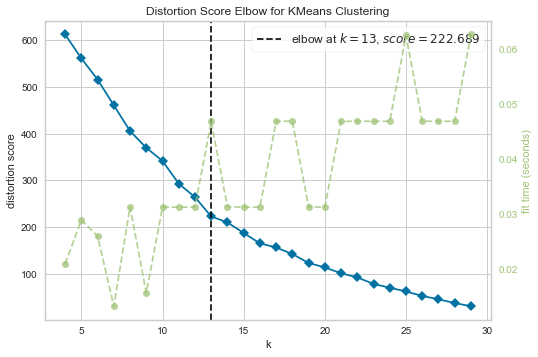

In [114]:
from yellowbrick.cluster import KElbowVisualizer

model = KMeans()
visualizer = KElbowVisualizer(model, k=(4,30))
visualizer.fit(X_std)
visualizer.show()

### Run k-means clustering algorithm with the optimum number of k

In [115]:
cluster_number = 13
kmeans = KMeans(n_clusters=cluster_number, random_state = 0)
kmeans.fit(X_std)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=13, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=0, tol=0.0001, verbose=0)

### Insert the resulting cluster label data to most popular venues per sector data

In [116]:
sector_venues_sorted.insert(0, 'cluster', kmeans.labels_)

### Merge the most popular venues per sector data with the sector center data and the bird species count data

In [117]:
merged = df_center
merged = merged.join(sector_venues_sorted.set_index('sector'), on='sector')
merged = pd.merge(merged, df_bird_count, on='sector')
merged = merged.dropna()
merged.head()

,center_lat,center_lon,sector,cluster,1st_most_common_venue,2nd_most_common_venue,3rd_most_common_venue,4th_most_common_venue,5th_most_common_venue,6th_most_common_venue,7th_most_common_venue,8th_most_common_venue,9th_most_common_venue,10th_most_common_venue,species_number
0,1.419471,103.727489,0,4.0,Food,Nature Reserve,Zoo,Mall,Clinic,Coast,College,Convenience Store,Elementary School,High School,239
1,1.314832,103.816201,1,8.0,Park,College,Food,Hospital,Bus Transit,Clinic,Convenience Store,Trail,Mall,School,208
2,1.396323,103.926179,2,12.0,Food,Coast,Convenience Store,Elementary School,Park,Zoo,Mall,Clinic,College,High School,230
3,1.357278,103.773335,3,10.0,Bus Transit,Trail,Food,Residence,Convenience Store,Rail Transit,Park,College,Clinic,School,239
4,1.268861,103.629649,4,4.0,Food,Zoo,Trail,Clinic,Coast,College,Convenience Store,Elementary School,High School,Hospital,206


### Rearrange the merged data column names

In [118]:
columns_list = list(merged.columns[:4]) + [merged.columns[-1]] + list(merged.columns[4:-1])
columns_list

['center_lat',
 'center_lon',
 'sector',
 'cluster',
 'species_number',
 '1st_most_common_venue',
 '2nd_most_common_venue',
 '3rd_most_common_venue',
 '4th_most_common_venue',
 '5th_most_common_venue',
 '6th_most_common_venue',
 '7th_most_common_venue',
 '8th_most_common_venue',
 '9th_most_common_venue',
 '10th_most_common_venue']

In [119]:
merged = merged[columns_list]

### Sort the merged data by cluster and convert the cluster data type into integer

In [120]:
merged = merged.sort_values(by='cluster')
merged = merged.astype({'cluster':int})
merged.head()

,center_lat,center_lon,sector,cluster,species_number,1st_most_common_venue,2nd_most_common_venue,3rd_most_common_venue,4th_most_common_venue,5th_most_common_venue,6th_most_common_venue,7th_most_common_venue,8th_most_common_venue,9th_most_common_venue,10th_most_common_venue
39,1.312899,103.705487,39,0,125,Zoo,Food,Bus Transit,Park,Mall,Coast,College,Hospital,Clinic,Convenience Store
15,1.405399,103.788914,15,0,158,Zoo,Food,Park,Rail Transit,Trail,Convenience Store,Bus Transit,Movie Theater,Theme Park,College
21,1.407939,103.873699,21,1,162,Food,Bus Transit,College,Coast,Preschool,Mall,Clinic,Convenience Store,Elementary School,High School
24,1.395490,103.988946,24,1,190,Food,Bus Transit,Coast,College,Convenience Store,Trail,Residence,Market,Park,Nature Reserve
6,1.363043,103.701017,6,1,135,Food,Bus Transit,Park,Mall,Clinic,Coast,College,Convenience Store,Elementary School,High School


In [121]:
merged.to_csv('merged.csv', index=False)

### Map the clusters

In [122]:
from geopy.geocoders import Nominatim
import matplotlib.cm as cm
import matplotlib.colors as colors

map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)
x1 = np.arange(cluster_number)
ys = [i + x1 + (i*x1)**2 for i in range(cluster_number)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

markers_colors = []

for lat, lon, sector, cluster, sp in zip(merged['center_lat'], merged['center_lon'], merged['sector'], merged['cluster'], merged['species_number']):
    label = folium.Popup('# Sector: ' + str(sector) + '# Cluster: ' + str(cluster) + '# Species number: ' + str(sp), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
    
map_clusters

## Results <a name='results'></a>

The Singapore bird observation data used in this study consists of 401067 rows and are plotted as follows:

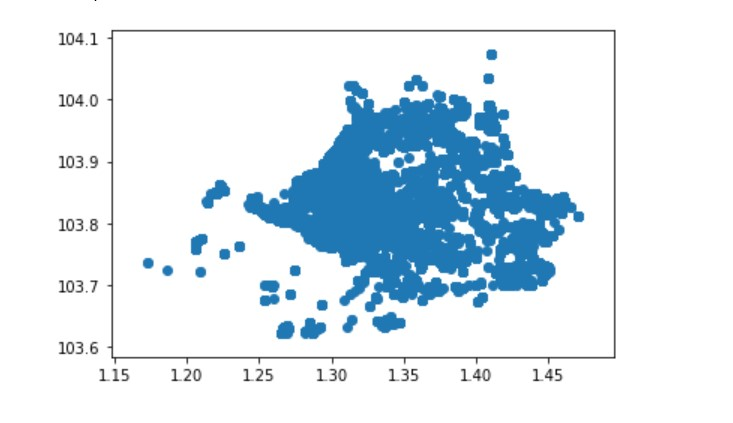

K-means clustering algorithm was implemented with the above Singapore bird observation data with 40 centroids. The result is plotted as follows:

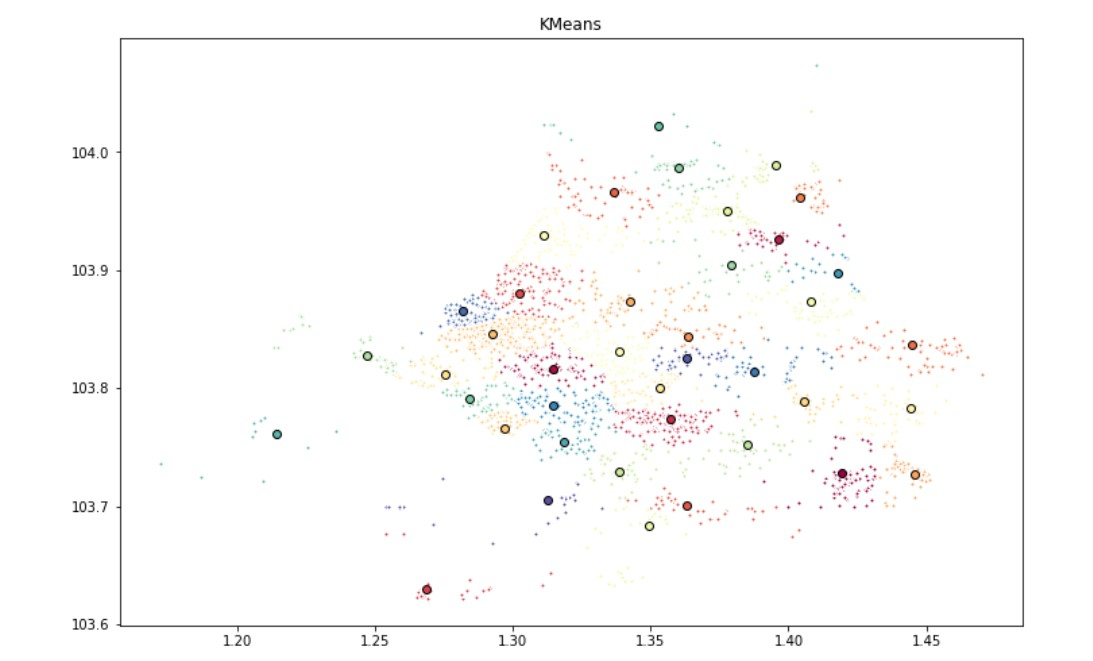

The centroids were then assigned as sectors. The sectors are plotted in map with Folium as follows:

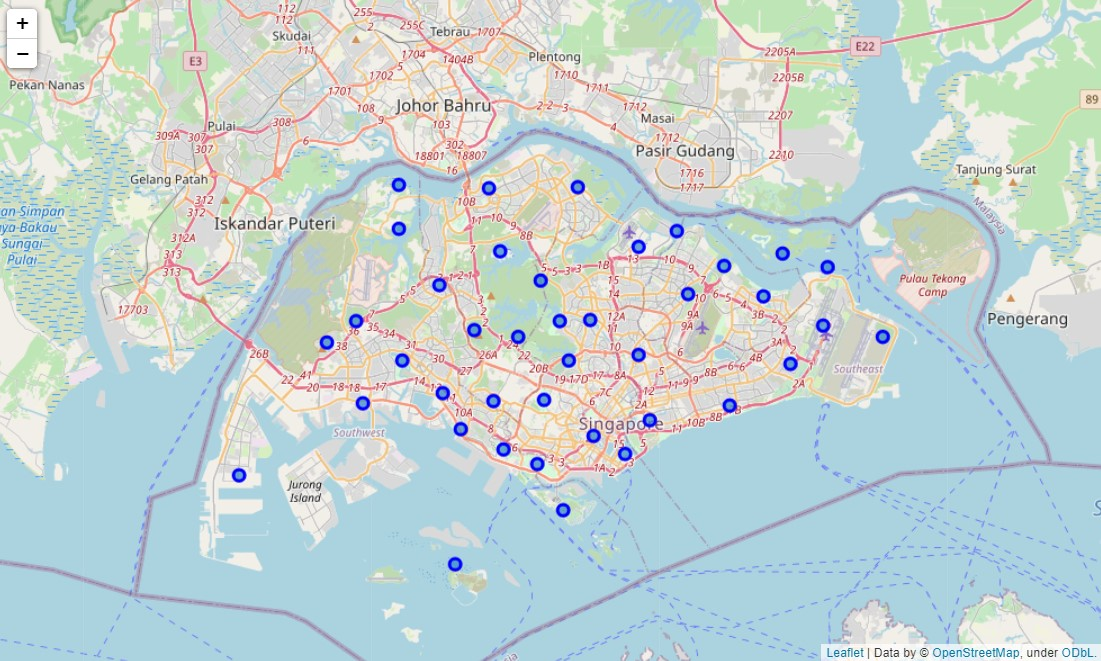

After collecting the venues and species number data for each sector, we again ran k-means clustering algorithm with the sectors data. Before that, 3 sectors were ommitted because there were no venues nearby.

The elbow method suggested 13 as the optimum number of k. However, as the curve seems continuous, it is expected that some of the resulting clusters would show high overlap with another.

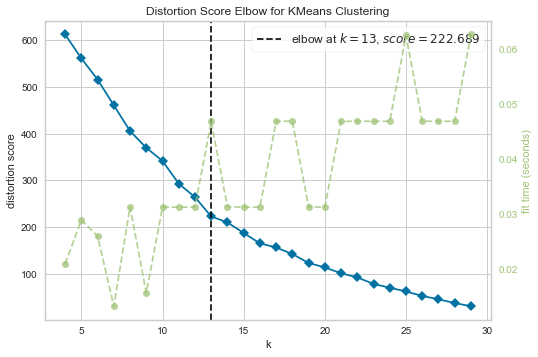

K-means algorithm were them implemented again with the sectors, producing the clusters that were mapped as follows:

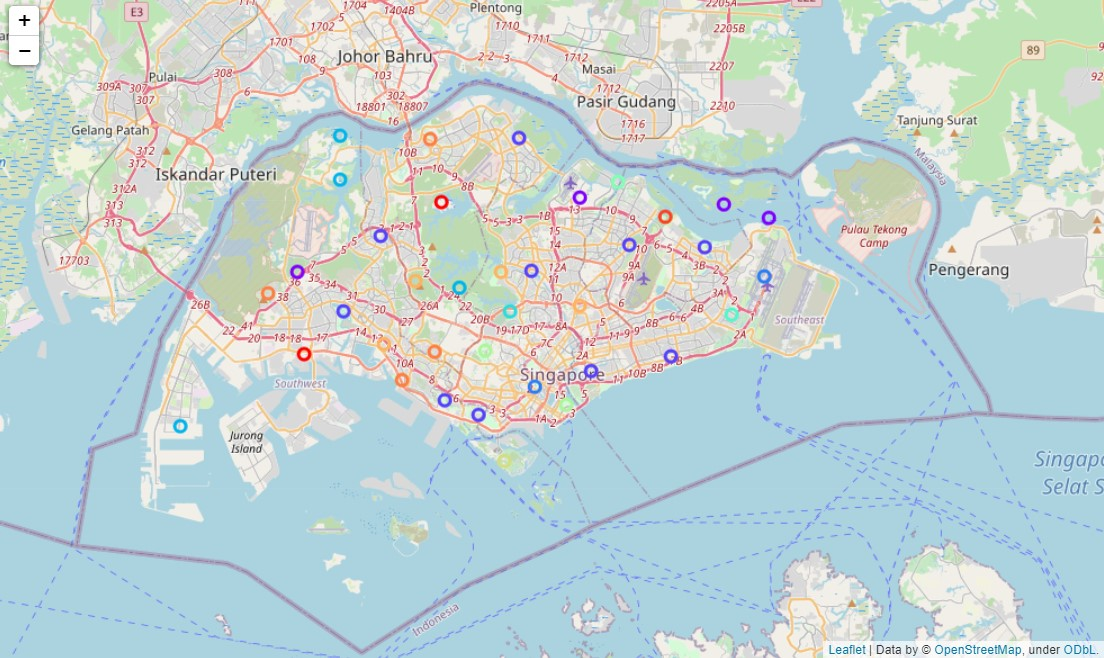

The table for the resulting clustering of sectors is as follows:

In [126]:
clustering_result1 = pd.read_csv('merged.csv')
clustering_result1

,center_lat,center_lon,sector,cluster,species_number,1st_most_common_venue,2nd_most_common_venue,3rd_most_common_venue,4th_most_common_venue,5th_most_common_venue,6th_most_common_venue,7th_most_common_venue,8th_most_common_venue,9th_most_common_venue,10th_most_common_venue
0,1.312899,103.705487,39,0,125,Zoo,Food,Bus Transit,Park,Mall,Coast,College,Hospital,Clinic,Convenience Store
1,1.405399,103.788914,15,0,158,Zoo,Food,Park,Rail Transit,Trail,Convenience Store,Bus Transit,Movie Theater,Theme Park,College
2,1.407939,103.873699,21,1,162,Food,Bus Transit,College,Coast,Preschool,Mall,Clinic,Convenience Store,Elementary School,High School
3,1.395490,103.988946,24,1,190,Food,Bus Transit,Coast,College,Convenience Store,Trail,Residence,Market,Park,Nature Reserve
4,1.363043,103.701017,6,1,135,Food,Bus Transit,Park,Mall,Clinic,Coast,College,Convenience Store,Elementary School,High School
5,1.403975,103.961384,9,1,260,Food,Convenience Store,Trail,Coast,Zoo,Clinic,College,Elementary School,High School,Hospital
6,1.377628,103.949707,23,2,223,Convenience Store,Bus Transit,Residence,Food,Park,Mall,College,Theme Park,Clinic,Coast
7,1.363694,103.844060,10,2,154,Residence,Convenience Store,Bus Transit,Food,Mall,Park,Clinic,High School,Coast,College
8,1.444676,103.836751,8,2,176,Residence,Bus Transit,Food,Convenience Store,Park,Mall,Market,Trail,Rail Transit,Elementary School
9,1.338778,103.729148,25,2,197,Bus Transit,Residence,Convenience Store,Food,Park,College,Preschool,Trail,Coast,Elementary School


## Discussion <a name='discussion'></a>

The clustering of Singapore area based on birds observation data and nearby venues produced 13 clusters. After considering the features of each clusters, the clusters can be named based on their characteristics as follows.
- Cluster 0 : Zoo
- Cluster 1 : Food
- Cluster 2 : Residence 1
- Cluster 3 : Mall
- Cluster 4 : Foo & Nature Reserve
- Cluster 5 : Hospital
- Cluster 6 : Bus Transit
- Cluster 7 : Coast 1
- Cluster 8 : Park
- Cluster 9 : Theme Park
- Cluster 10 : Residence 2
- Cluster 11 : College
- Cluster 12 : Coast 2

In [128]:
clustering_result2 = pd.read_csv('merged4.csv')
clustering_result2

,center_lat,center_lon,sector,cluster,cluster_name,species_number,1st_most_common_venue,2nd_most_common_venue,3rd_most_common_venue,4th_most_common_venue,5th_most_common_venue,6th_most_common_venue,7th_most_common_venue,8th_most_common_venue,9th_most_common_venue,10th_most_common_venue
0,1.405399,103.788914,15,0,Zoo,158,Zoo,Food,Park,Rail Transit,Trail,Convenience Store,Bus Transit,Movie Theater,Theme Park,College
1,1.312899,103.705487,39,0,Zoo,125,Zoo,Food,Bus Transit,Park,Mall,Coast,College,Hospital,Clinic,Convenience Store
2,1.403975,103.961384,9,1,Food,260,Food,Convenience Store,Trail,Coast,Zoo,Clinic,College,Elementary School,High School,Hospital
3,1.395490,103.988946,24,1,Food,190,Food,Bus Transit,Coast,College,Convenience Store,Trail,Residence,Market,Park,Nature Reserve
4,1.407939,103.873699,21,1,Food,162,Food,Bus Transit,College,Coast,Preschool,Mall,Clinic,Convenience Store,Elementary School,High School
5,1.363043,103.701017,6,1,Food,135,Food,Bus Transit,Park,Mall,Clinic,Coast,College,Convenience Store,Elementary School,High School
6,1.377628,103.949707,23,2,Residence 1,223,Convenience Store,Bus Transit,Residence,Food,Park,Mall,College,Theme Park,Clinic,Coast
7,1.338778,103.729148,25,2,Residence 1,197,Bus Transit,Residence,Convenience Store,Food,Park,College,Preschool,Trail,Coast,Elementary School
8,1.275609,103.811885,16,2,Residence 1,191,Residence,Bus Transit,Convenience Store,Food,College,Mall,Clinic,Park,High School,Preschool
9,1.444676,103.836751,8,2,Residence 1,176,Residence,Bus Transit,Food,Convenience Store,Park,Mall,Market,Trail,Rail Transit,Elementary School


The cluster that contains the most sectors is Residence 1 (10 sectors). Clusters Residence 2, College, Food & Nature Reserve, and Food have the second most sectors with 4 sectors each.

There are multipe approach to using the resulting information to decide which area to choose. One of the ways is to simply sort the species number of all sectors and then select which of the top sectors have the most favorable venues. In this discussion part, we will decide which area to choose by first choosing the clusters we would like to live in, sort the bird species numbers and then select a few sectors from those for more specific consideration.

First, we would like to choose the Residence 1 and Residence 2 clusters. These clusters are dominated by residential areas. The assumption is that the more extensive the residence are are, the more the house price would decrease because of competition. So we choose those Residence clusters because there may be more alternatives in terms of price range and the overall price may be less expensive than the houses in the less denser area.

In [152]:
choose = clustering_result2[(clustering_result2['cluster_name'] == 'Residence 1') | (clustering_result2['cluster_name'] == 'Residence 2')]
choose = choose.sort_values(by=['species_number'], ascending=False)
choose.to_csv('choose.csv', index=False)
choose

,center_lat,center_lon,sector,cluster,cluster_name,species_number,1st_most_common_venue,2nd_most_common_venue,3rd_most_common_venue,4th_most_common_venue,5th_most_common_venue,6th_most_common_venue,7th_most_common_venue,8th_most_common_venue,9th_most_common_venue,10th_most_common_venue
28,1.342370,103.873404,12,10,Residence 2,260,Residence,Bus Transit,Convenience Store,Food,High School,College,Park,School,Rail Transit,Preschool
29,1.357278,103.773335,3,10,Residence 2,239,Bus Transit,Trail,Food,Residence,Convenience Store,Rail Transit,Park,College,Clinic,School
6,1.377628,103.949707,23,2,Residence 1,223,Convenience Store,Bus Transit,Residence,Food,Park,Mall,College,Theme Park,Clinic,Coast
30,1.363178,103.825321,38,10,Residence 2,203,Bus Transit,Residence,Food,Trail,High School,College,Park,Convenience Store,School,Nature Reserve
7,1.338778,103.729148,25,2,Residence 1,197,Bus Transit,Residence,Convenience Store,Food,Park,College,Preschool,Trail,Coast,Elementary School
8,1.275609,103.811885,16,2,Residence 1,191,Residence,Bus Transit,Convenience Store,Food,College,Mall,Clinic,Park,High School,Preschool
9,1.444676,103.836751,8,2,Residence 1,176,Residence,Bus Transit,Food,Convenience Store,Park,Mall,Market,Trail,Rail Transit,Elementary School
10,1.302243,103.880420,5,2,Residence 1,155,Bus Transit,Residence,Food,Convenience Store,College,Clinic,Preschool,Mall,High School,Rail Transit
11,1.311450,103.929386,19,2,Residence 1,155,Bus Transit,Residence,Convenience Store,Food,Clinic,Coast,College,Park,Mall,Preschool
12,1.363694,103.844060,10,2,Residence 1,154,Residence,Convenience Store,Bus Transit,Food,Mall,Park,Clinic,High School,Coast,College


The final selection of the area to choose to live in would depend on respective users. For this discussion, we will use the author's preferences. Based on the selected cluster, sorted bird species numbers, and the features of the sector, we choose sector 23 and sector 16. The considerations are:

- These sectors have relatively high bird species diversity
- The residence area of these sectors are quite dominant, so the housing prices may be lower
- These sectors have desirable venues, namely mall, convenience store, clinic, bus transit, food, park

After further checking in Google Maps, it is known that the sector 23 (lat/lon: 1.377628/103.949707) is Pasir Ris area on the northeast coast of Singapore island near Changi Airport. Sector 16 (lat/lon: 1.275609/103.811885) is Bukit Merah area on the south part of Singapore. So, based on the analysis on this study, the choice for the author's place of residence where there are maximum experience for birdwatching and there are more desirable venues nearby are:

- Primary: Pasir Ris area

- Secondary: Bukit Merah area

Pasir Ris is also the preferred choice of residence for the author because from there he would have shorter access to the Changi airport any time he wants to come home to his hometown of Jakarta, Indonesia.

## Conclusion <a name='conclusion'></a>

In this study we have analyzed Singapore bird observation data and Foursquare API venues data to produce insights that may be useful for birdwatchers find the best area to live in Singapore. The insights may point birdwatchers to areas where there are maximum birdwatching experience and desireable venues. The results of the study were maps of 13 clusters that consisted of 37 sectors and table that listed most common venues for each sectors. The final decision will depend on each users' needs, desireable features of an area, and other information that are not captured in the datasets. However, the analysis, maps and table may serve as useful baseline information for real-life use case of birdwatchers choosing an area of residence in Singapore.

## References <a name='references'></a>

1. Vidovich, E. Bringing the Outdoors In: The Benefits of Biophilia. NRDC: Expert Blog. Last accessed on 21/01/2021. <a name='r1'></a> [link](https://www.nrdc.org/experts/maria-mccain/bringing-outdoors-benefits-biophilia)
2. White, J. How popular is birdwatching? Chirpbirding.com. Last accessed on 21/01/2021. <a name='r2'></a> [link](https://chirpbirding.com/blog/81/how-popular-is-birdwatching/#:~:text=Millions%20of%20people%20are%20birdwatchers,is%20spent%20birdwatching%20than%20gardening)
3. GBIF.org (13 January 2021) GBIF Occurrence. Download: <a name='r3'></a> [link](https://doi.org/10.15468/dl.43xha7)